# A classifier for incident reports

![image alt >](https://www.skycop.com/media/list-of-flight-incidents-and-strikes-in-2019.jpg)

<img src="https://static.designboom.com/wp-content/uploads/2017/02/pearsonlloyd-lufthansa-A350-economy-class-cabin-interiors-designboom-02.jpg" width=300 height=300>

<!-- <img src="https://static.designboom.com/wp-content/uploads/2017/02/pearsonlloyd-lufthansa-A350-economy-class-cabin-interiors-designboom-02.jpg" width=300 height=300> -->




## Objective: 
With the provided data set, <span style="color:blue"> <em>**propose an accurate incident classification system**</em></span> based on the data included in every incident report.


In [5]:
!python -V

Python 3.5.6 :: Anaconda, Inc.


In [6]:
import io
import sklearn as skl
import keras
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,\
     CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate


from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
%matplotlib inline

Using TensorFlow backend.


In [7]:
!dir .

 Volume in drive C is Local Disk
 Volume Serial Number is 4CBC-7ADE

 Directory of C:\Users\AC228227\Documents\IATA_challenge\IATA_challenge

06/14/2019  05:16 PM    <DIR>          .
06/14/2019  05:16 PM    <DIR>          ..
06/11/2019  05:33 PM    <DIR>          .ipynb_checkpoints
06/11/2019  05:26 PM        16,064,847 Dataset_deidentified_20K.csv
06/11/2019  05:26 PM         7,674,343 Dataset_deidentified_20K.xlsx
06/11/2019  05:26 PM             3,890 IATA_Incident_classification.ipynb
06/14/2019  05:16 PM            64,580 IATA_Incident_classification_local.ipynb
06/11/2019  05:26 PM               690 IATA_Setup.txt
06/12/2019  02:46 PM       320,011,325 RandomForest.pickle
               6 File(s)    343,819,675 bytes
               3 Dir(s)  445,054,869,504 bytes free


In [8]:
# input_dir = "/content/drive/My Drive/IATA_Datathon/"

input_dir ="./"
input_file = input_dir+"Dataset_deidentified_20K.csv"

raw_df  = pd.read_csv(input_file)
input_file



'./Dataset_deidentified_20K.csv'

## Dataset schema

In [9]:
types_df = pd.DataFrame(raw_df.dtypes, columns=["type"])
types_df

,type
Report ID,int64
EventTitle,object
Summary,object
Altitude Deviation,int64
Birdstrike,int64
Deep Landing,int64
EGPWS,int64
Hard/Heavy Landing,int64
Runway/Taxiway Incursion,int64
Rejected Take Off,int64


In [10]:
raw_df.head()

,Report ID,EventTitle,Summary,Altitude Deviation,Birdstrike,Deep Landing,EGPWS,Hard/Heavy Landing,Runway/Taxiway Incursion,Rejected Take Off,...,Passenger and Cabin Crew Injury,Rapid Deplaning and Evacuation,Turbulence,Brakes and Steering,Cabin Pressurization,Engine Surge and Stall,Engine Shutdown,Flight Controls,ATC Service Standard,Security
0,0,LOW ENERGY WARNING,"during visual approach at rho runway 25, at 14...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Engines fluctuations in cruise.,engines fluctuations in cruise. levelling off ...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,Door 1L slide bustle deployed onto jetty,"** please see also incident no 980802, which d...",0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3,LONG LANDING RWY 21 - PER,qpilot: Touchdown Approx 2500 (**** submitted ...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,BIRD STRIKE,la base smr reporta condicion 2 por impacto de...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Getting category names

In [11]:
categ_names = list(raw_df.columns.values)
del categ_names[0:3]
# categ_names


## ***Counting records by Category***

In [12]:
stat_categ=[]
for categ in categ_names:
    stat_categ.append((categ, raw_df[categ].sum()))
    
stat_categ = pd.DataFrame(stat_categ, columns=["category","count"]).sort_values(by=["count"], ascending=False)  
  

Text(0.5, 0, 'Category')

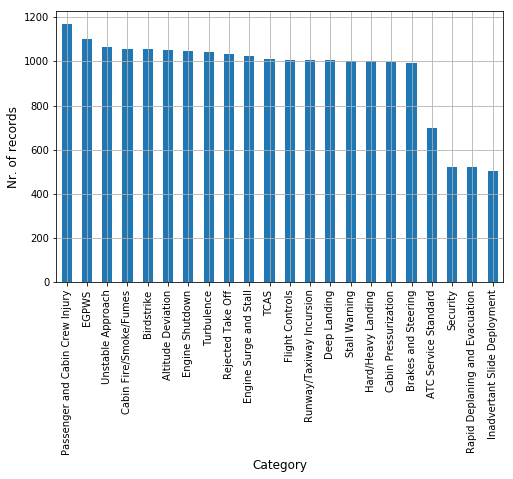

In [13]:
stat_categ.plot(x='category', y='count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.ylabel('Nr. of records', fontsize=12)
plt.xlabel('Category', fontsize=12)

## Preparing the dataset for multi-class classification

In [14]:
a = pd.Series(list(raw_df[categ_names].idxmax(1)))
a.rename("Category",inplace=True)
feats_df = pd.concat([raw_df[list(raw_df.columns.values)[1:3]],a],1) 

In [15]:
feats_df["Categ_idx"] = feats_df["Category"].apply(categ_names.index)

In [16]:
feats_df.head(3)

,EventTitle,Summary,Category,Categ_idx
0,LOW ENERGY WARNING,"during visual approach at rho runway 25, at 14...",Stall Warning,7
1,Engines fluctuations in cruise.,engines fluctuations in cruise. levelling off ...,Engine Surge and Stall,17
2,Door 1L slide bustle deployed onto jetty,"** please see also incident no 980802, which d...",Rapid Deplaning and Evacuation,13


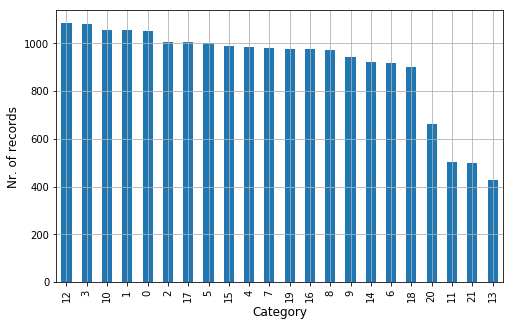

In [17]:
feats_df.groupby('Categ_idx').Summary.count().sort_values(ascending=False).plot(x='category', y='count', 
                                                                                kind='bar', legend=False, 
                                                                                grid=True, figsize=(8, 5))

plt.ylabel('Nr. of records', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [18]:
feats_df.shape;
feats_df['Summary'].head(1)

0    during visual approach at rho runway 25, at 14...
Name: Summary, dtype: object

In [19]:
import nltk
nltk.download("stopwords")

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [20]:
stemmer = PorterStemmer()
words = stopwords.words("english")
feats_df['cleaned'] = (feats_df['EventTitle']+' '+feats_df['Summary']).apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", str(x)).split() if i not in words]).lower())

In [21]:
feats_df.head(3)

,EventTitle,Summary,Category,Categ_idx,cleaned
0,LOW ENERGY WARNING,"during visual approach at rho runway 25, at 14...",Stall Warning,7,low energi warn visual approach rho runway ft ...
1,Engines fluctuations in cruise.,engines fluctuations in cruise. levelling off ...,Engine Surge and Stall,17,engin fluctuat cruis engin fluctuat cruis leve...
2,Door 1L slide bustle deployed onto jetty,"** please see also incident no 980802, which d...",Rapid Deplaning and Evacuation,13,door l slide bustl deploy onto jetti pleas see...


In [22]:

#instantiate CountVectorizer()
cv=CountVectorizer()
 
# this steps generates word counts for the words in your docs
word_count_vector=cv.fit_transform(feats_df['cleaned'])
word_count_vector.shape

(20000, 36775)

In [23]:
vectorizer=TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [24]:
final_features = vectorizer.fit_transform(feats_df['cleaned']).toarray()
final_features.shape

(20000, 85165)

In [25]:
# tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
# tfidf_transformer.fit(word_count_vector)

# # print idf values
# df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["tf_idf_weights"])
 
# # sort ascending
# df_idf.sort_values(by=['tf_idf_weights'])

## Model pipeline implementation (random Forest) -first stand-alone implementation

In [26]:
# this block is to split the dataset into training and testing set 
X = feats_df['cleaned']
Y = feats_df['Categ_idx']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
# instead of doing these steps one at a time, we can use a pipeline to complete them all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=10000)),
                     ('clf', RandomForestClassifier(n_estimators=100, random_state=10))])
# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)
ytest = np.array(y_test)
# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       323
           1       0.90      0.94      0.92       320
           2       0.92      0.94      0.93       314
           3       0.80      0.88      0.84       346
           4       0.83      0.87      0.85       287
           5       0.77      0.93      0.84       280
           6       0.71      0.83      0.77       264
           7       0.92      0.85      0.88       295
           8       0.83      0.97      0.90       270
           9       0.68      0.72      0.70       277
          10       0.78      0.98      0.87       301
          11       0.81      0.95      0.88       154
          12       0.80      0.84      0.82       319
          13       0.71      0.29      0.41       118
          14       0.72      0.69      0.71       285
          15       0.85      0.85      0.85       320
          16       0.92      0.85      0.88       277
          17       0.82    

In [27]:
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=True,
                                 token_patter...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=

In [28]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold(n_splits=K, shuffle=True, random_state=10)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)#, scoring='roc_auc')
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores)))
    
    

## Pipeline implementation for different models

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('chi',  SelectKBest(chi2, k=10000)),
    ('clf', MultinomialNB()),
])
clf_2 = Pipeline([
    ('vect', HashingVectorizer()),
    ('chi',  SelectKBest(chi2, k=10000)),
    ('clf', MultinomialNB()),
])
clf_3 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('chi',  SelectKBest(chi2, k=10000)),
    ('clf', MultinomialNB()),
])
clf_4 = Pipeline([
    ('vect', TfidfVectorizer(
                token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",
    )),
    ('clf', MultinomialNB()),
])

In [30]:
evaluate_cross_validation(pipeline, feats_df["cleaned"], feats_df["Category"],5)

[0.8225  0.8165  0.819   0.81525 0.82425]
Mean score: 0.820 (+/-0.002)


## Evaluating effect of vectorization on the model performance using K-fold cross validation

In [31]:
clfs = [clf_1, clf_3, clf_4, pipeline]
for clf in clfs:
    evaluate_cross_validation(clf, feats_df["cleaned"], feats_df["Category"], 5)

[0.77675 0.78075 0.7675  0.76925 0.77975]
Mean score: 0.775 (+/-0.003)
[0.7615  0.76275 0.745   0.759   0.7625 ]
Mean score: 0.758 (+/-0.003)
[0.7525  0.74875 0.744   0.75425 0.758  ]
Mean score: 0.751 (+/-0.002)
[0.8225  0.8165  0.819   0.81525 0.82425]
Mean score: 0.820 (+/-0.002)


In [32]:
# list(zip(train[features], clf.feature_importances_))